# Univariate Time Series Analysis and Benchmark

## Load Libs and Data

In [1]:
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import utils
import plotly.express as px
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,7)
import warnings
warnings.filterwarnings('ignore')

### Get Store 22 Data

In [2]:
store_id = 22

In [3]:
all_stores = pd.read_csv("data/sales-data-set.csv")
store = all_stores[all_stores["Store"] == store_id]
store.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
207131     22     1  05/02/2010      20686.31      False
207132     22     1  12/02/2010      36372.35       True
207133     22     1  19/02/2010      23035.70      False
207134     22     1  26/02/2010      14843.93      False
207135     22     1  05/03/2010      19011.63      False

### Duplicate and null checks

In [4]:
store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9688 entries, 207131 to 216818
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         9688 non-null   int64  
 1   Dept          9688 non-null   int64  
 2   Date          9688 non-null   object 
 3   Weekly_Sales  9688 non-null   float64
 4   IsHoliday     9688 non-null   bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 387.9+ KB


In [5]:
print(utils.check_duplicates(store))

0


### Datetime indexing holidays

In [6]:
holidays = store[["Date", "IsHoliday"]]
holidays = holidays.drop_duplicates()
holidays = utils.set_datetime_index(df=holidays, date_col="Date",date_format="%d/%m/%Y")
holidays = utils.reindex(holidays, "W-FRI")
holidays.index

New Index = 143, existing index = 143
Setting index to new index


DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', length=143, freq='W-FRI')

### Load consumer price index

In [7]:
cpi = pd.read_csv("data/features-data-set.csv")[["Store","Date", "CPI"]]
cpi= cpi[cpi["Store"] == store_id]
cpi = utils.set_datetime_index(df=cpi, date_col="Date",date_format="%d/%m/%Y")
cpi = utils.reindex(cpi)
cpi.drop("Store", inplace=True, axis=1)
cpi.index

New Index = 182, existing index = 182
Setting index to new index


DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2013-05-24', '2013-05-31', '2013-06-07', '2013-06-14',
               '2013-06-21', '2013-06-28', '2013-07-05', '2013-07-12',
               '2013-07-19', '2013-07-26'],
              dtype='datetime64[ns]', length=182, freq='W-FRI')

### Group Sales by department

In [8]:
store_sales = store.groupby(["Date", "Store"]).agg({"Weekly_Sales": "sum"}).reset_index()
store_sales.drop("Store", inplace=True, axis=1)
store_sales.describe(include="all")

Date  Weekly_Sales
count          143  1.430000e+02
unique         143           NaN
top     26/03/2010           NaN
freq             1           NaN
mean           NaN  1.028501e+06
std            NaN  1.612514e+05
min            NaN  7.742623e+05
25%            NaN  9.614760e+05
50%            NaN  9.966288e+05
75%            NaN  1.052934e+06
max            NaN  1.962445e+06

### Validate datetime index, set frequency, merge datasets

In [9]:
store_sales = utils.set_datetime_index(df=store_sales, date_col="Date",date_format="%d/%m/%Y")
store_sales = utils.reindex(store_sales)
store_sales.index

New Index = 143, existing index = 143
Setting index to new index


DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', length=143, freq='W-FRI')

In [10]:
# merge holidays and store sales
store_sales = store_sales.merge(holidays, how="left", left_index=True, right_index=True)
store_sales["Week"] = store_sales.index.week
store_sales["Month"] = store_sales.index.month
store_sales[store_sales["IsHoliday"]==True]

Weekly_Sales  IsHoliday  Week  Month
2010-02-12    1022571.25       True     6      2
2010-09-10     924174.40       True    36      9
2010-11-26    1564502.26       True    47     11
2010-12-31     774262.28       True    52     12
2011-02-11    1009206.33       True     6      2
2011-09-09    1004434.54       True    36      9
2011-11-25    1535857.49       True    47     11
2011-12-30     982661.14       True    52     12
2012-02-10    1034448.07       True     6      2
2012-09-07     996628.80       True    36      9

For holidays, week numbers seem to be aligned.  This will help us to see seasonal patterns clearly by aligning the week numbers instead of trying to align the week dates, which I spent considerable amount of time tyring to do. Lesson learned.

In [11]:
store_sales = store_sales.merge(cpi, how="left", left_index=True, right_index=True)
store_sales.head()

Weekly_Sales  IsHoliday  Week  Month         CPI
2010-02-05    1033017.37      False     5      2  135.352461
2010-02-12    1022571.25       True     6      2  135.411308
2010-02-19     988467.61      False     7      2  135.465778
2010-02-26     899761.48      False     8      2  135.519519
2010-03-05    1009201.24      False     9      3  135.573260

### Adjust sale dollar amount to Consumer Price Index
This will reveal the true trend in sales regardless of varying buying power.

In [12]:
store_sales["Weekly_Sales_Adjusted"] = (store_sales["Weekly_Sales"] / store_sales["CPI"]) * 100
display(store_sales.index)
store_sales.head()

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', length=143, freq='W-FRI')

Weekly_Sales  IsHoliday  Week  Month         CPI  \
2010-02-05    1033017.37      False     5      2  135.352461   
2010-02-12    1022571.25       True     6      2  135.411308   
2010-02-19     988467.61      False     7      2  135.465778   
2010-02-26     899761.48      False     8      2  135.519519   
2010-03-05    1009201.24      False     9      3  135.573260   

            Weekly_Sales_Adjusted  
2010-02-05          763205.459210  
2010-02-12          755159.423629  
2010-02-19          729680.679404  
2010-02-26          663934.971121  
2010-03-05          744395.494002

## Weekly Sales

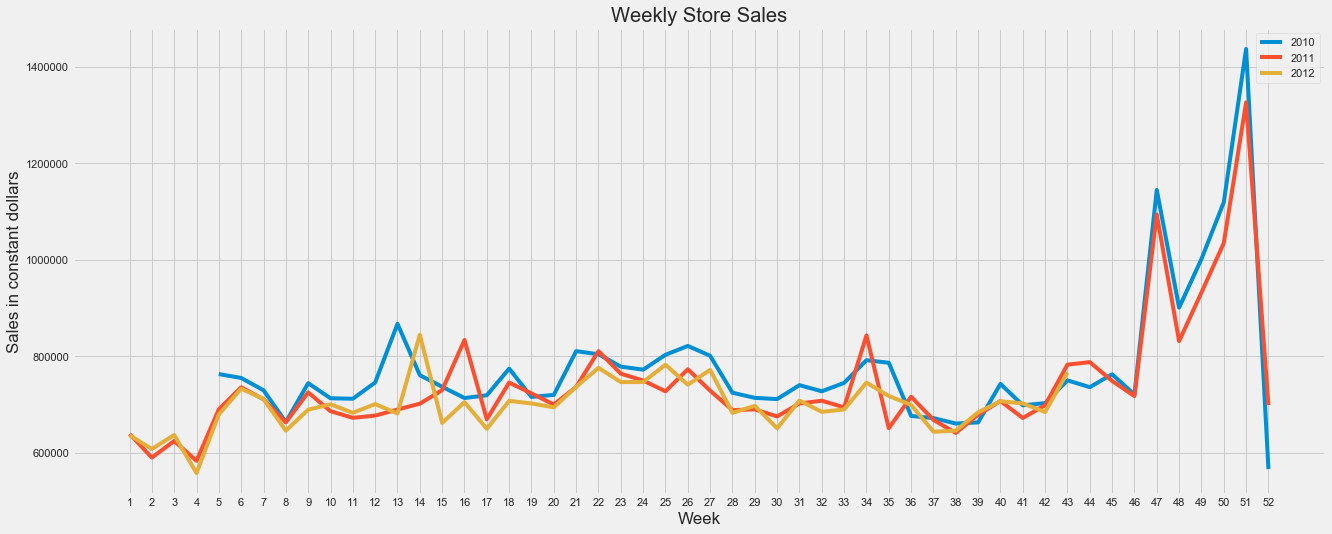

In [13]:
plt.figure(figsize=(20, 8))
for y in [2010,2011,2012]:
    year_group = store_sales[store_sales.index.year == y]
    plt.plot(year_group.index.week, year_group["Weekly_Sales_Adjusted"], label=y)

plt.legend()
plt.title("Weekly Store Sales")
plt.xlabel("Week")
plt.ylabel("Sales in constant dollars")
plt.xticks(np.arange(1,53))
plt.show();
    

Seasonality is pretty clear in above graph with lag shifts between 10th and 20th week. This store sales seems to be lower in 2012 comparative to previous 2 years. We don't have full 2 seasons of data, but it seems like sales each week are pretty close to each other with some variation every year.

## AutoCorrelation Plot

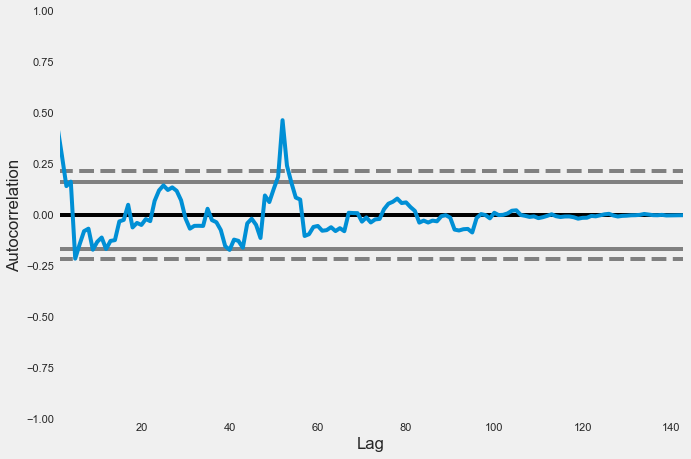

In [14]:
pd.plotting.autocorrelation_plot(store_sales["Weekly_Sales_Adjusted"]);

The graph above confirms that the most significant seasonality here is yearly.

## Decomposition and stationarity check
- We know the dataset is not stationary, as we confirmed that there is a strong yearly seasonality. 
- Above sequence plot showed that 2012 might have lower sales, but haven't confirmed that trend yet. 
- The amount of seasonality doesn't seem to be increasing through time; we can use an additive model.

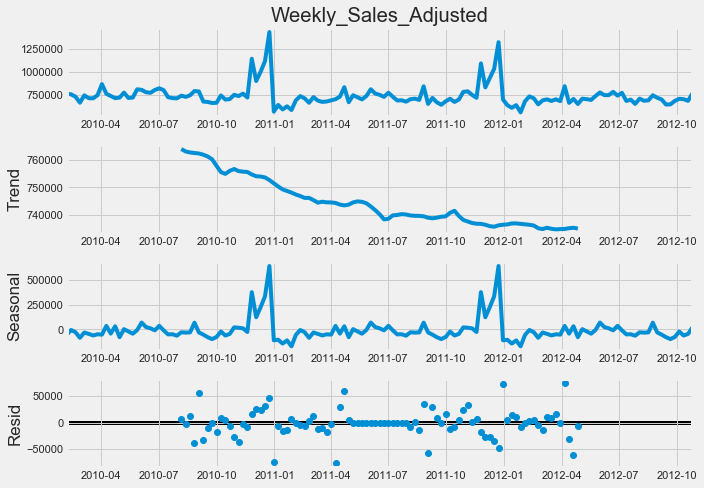

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=store_sales["Weekly_Sales_Adjusted"], model="additive", period=52)

estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

ss_decomposition.plot()
plt.show()

I used yearly seasonality to decompose the timeseries, but we should keep in mind that, we would need more data to be
able to fit this model better. At least 4 or 5 cycles are recommended to fit seasonal data. We have 52 periods of frequency, so ideally we would have 208 weeks of data.

In [16]:
round(estimated_trend.max() - estimated_trend.min(), 2)

29152.57

This plot shows a downward linear trend for about 30,000 constant dollars, which makes sense. We saw a hint of this in above sequence plot. The seasonal plot also looks good, capturing the yearly seasonality. Residuals look random, but I will check.

## Residuals

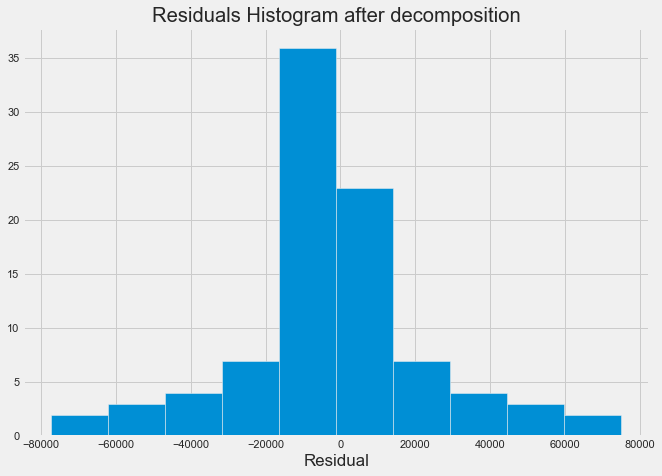

In [17]:
plt.hist(estimated_residual)
plt.title("Residuals Histogram after decomposition")
plt.xlabel("Residual");

Residuals distribution looks Gaussian. After subtracting seasonality and trend from the dataset, we are left with random noise.

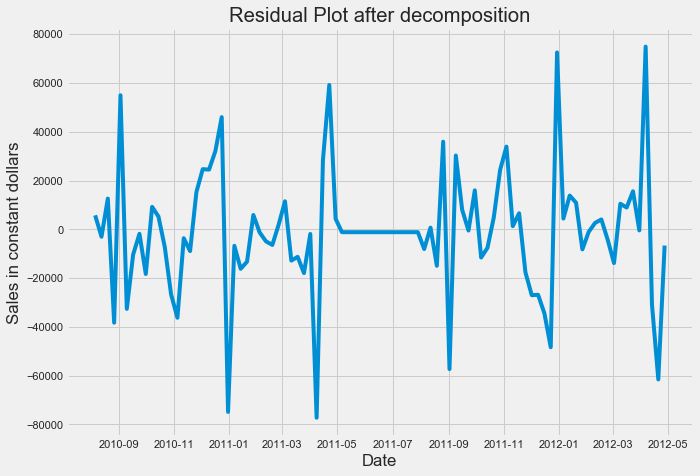

In [18]:
plt.xlabel("Date")
plt.ylabel("Sales in constant dollars")
plt.title("Residual Plot after decomposition")
plt.plot(estimated_residual);

In [19]:
print("Bias: ", estimated_residual.mean())

Bias:  -1155.725634096811


In [20]:
print("Std: ", estimated_residual.std())

Std:  25898.193564117206


After decomposing the series into its seasonality, trend and noise components, the residuals we are left with look normal, but we see high variation and bias.

In [21]:
q1, q2,q3 = np.percentile(estimated_residual.fillna(0), [25,50,75])
iqr = (q3 - q1) * 1.5
low = q1 - iqr
high = q3 + iqr
print(low, high)
print("Top UnderEstimates")
display(estimated_residual[estimated_residual > high].sort_values(ascending=False).iloc[:5])
print("Top OverEstimates")
estimated_residual[estimated_residual < low].sort_values(ascending=True).iloc[:5]

-6692.011714927887 4592.33978600408
Top UnderEstimates


2012-04-06    74958.122102
2011-12-30    72569.149272
2011-04-22    59233.137601
2010-09-03    55004.366724
2010-12-24    46036.526998
Name: resid, dtype: float64

Top OverEstimates


2011-04-08   -77269.573370
2010-12-31   -74880.600540
2012-04-20   -61544.588870
2011-09-02   -57315.817992
2011-12-23   -48347.978267
Name: resid, dtype: float64

 Highest errors are made on Easter, SuperBowl and Christmas weeks. Easter is not flagged as a holiday in the dataset, and falls on a different week each year: 
 - Easter 2011: April 24: 2011-04-22 Week: underestimated
 - Easter 2012: April 8: 2012-04-06 Week : underestimated

## Benchmark Forecast
Because we have a strong seasonality, I'm going to use naive seasonal forecast as the benchmark model. The benchmark model will predict the sale at time t as below:

$ Sales_t = Sales_{t-52} $

### CPI is not going to be available at the time of forecast, I will use previous week's CPI to deflate the sales.

In [22]:
store_sales.head()

Weekly_Sales  IsHoliday  Week  Month         CPI  \
2010-02-05    1033017.37      False     5      2  135.352461   
2010-02-12    1022571.25       True     6      2  135.411308   
2010-02-19     988467.61      False     7      2  135.465778   
2010-02-26     899761.48      False     8      2  135.519519   
2010-03-05    1009201.24      False     9      3  135.573260   

            Weekly_Sales_Adjusted  
2010-02-05          763205.459210  
2010-02-12          755159.423629  
2010-02-19          729680.679404  
2010-02-26          663934.971121  
2010-03-05          744395.494002

In [23]:
# Shift CPI forward
lastweek_cpi = store_sales[["CPI"]]
lastweek_cpi = lastweek_cpi.shift(1)
lastweek_cpi.head()

CPI
2010-02-05         NaN
2010-02-12  135.352461
2010-02-19  135.411308
2010-02-26  135.465778
2010-03-05  135.519519

In [24]:
store_sales_processed = store_sales[["Weekly_Sales", "Week", "IsHoliday"]]
store_sales_processed = store_sales_processed.merge(lastweek_cpi, how="left", left_index=True, right_index=True)
store_sales_processed["Adjusted_Weekly_Sales"] = (store_sales_processed["Weekly_Sales"] / store_sales_processed["CPI"]) * 100
store_sales_processed.dropna(inplace=True)
store_sales_processed.head()

Weekly_Sales  Week  IsHoliday         CPI  Adjusted_Weekly_Sales
2010-02-12    1022571.25     6       True  135.352461          755487.742119
2010-02-19     988467.61     7      False  135.411308          729974.200471
2010-02-26     899761.48     8      False  135.465778          664198.362583
2010-03-05    1009201.24     9      False  135.519519          744690.688620
2010-03-12     967187.37    10      False  135.573260          713405.702993

I'm going to use IsHoliday column to calculate the weighted error.

### Forecast Error
**The questions I want to answer:**
- Bias: Historical average error. Will the forecast be on average too high (overshoot the demand), or undershoot?
- Variance: How skilled the forecast is for generalizing underlying seasonality and trend.

In [25]:
def naive_seasonal_forecast(store_sales):
    """Naive seasonal forecast which predicts last year's same week"""
    
    result = store_sales[["Weekly_Sales", "Adjusted_Weekly_Sales", "CPI", "Week", "IsHoliday"]]
    shifted = result.shift(52)
    result = pd.concat([result, shifted], axis=1)
    print(result.columns)
    columns = ["Weekly_Sales", "Adjusted_Weekly_Sales", "CPI", "Week", "IsHoliday", "WeeklySales_t-52", "Adjusted_Weekly_Sales_t-52", "CPI_t-52", "Week_t-52", "IsHoliday_t-52"]
    result.columns = columns
    result["Weight"] = result["IsHoliday"].map(lambda x: 5 if x else 1)
    result["Error"] = result["Adjusted_Weekly_Sales"] - result["Adjusted_Weekly_Sales_t-52"]
    result["Holiday_Weighted_Error"] = result.apply(lambda row: (5 * row["Error"]) if row["IsHoliday"] else row["Error"], axis=1)
    
    return result

In [26]:
# Assure same partitions for benchmark and ARIMA (Test should start on 2012-08-03 for the enxt 3 months forecast, weekly granularity)
train_df = store_sales_processed.loc[ :"2012-08-03"]

In [27]:
train_df.tail()

Weekly_Sales  Week  IsHoliday         CPI  Adjusted_Weekly_Sales
2012-07-06    1097786.14    27      False  142.192038          772044.732370
2012-07-13     971361.38    28      False  142.223430          682982.671256
2012-07-20     991969.37    29      False  142.254821          697318.628808
2012-07-27     925731.21    30      False  142.233757          650851.970852
2012-08-03    1007257.83    31      False  142.212692          708275.620833

In [28]:
test_df = naive_seasonal_forecast(store_sales_processed) # train doesn't have enough periods
test_df.dropna(inplace=True)
test_df = test_df.loc["2012-08-10":]
test_df

Index(['Weekly_Sales', 'Adjusted_Weekly_Sales', 'CPI', 'Week', 'IsHoliday',
       'Weekly_Sales', 'Adjusted_Weekly_Sales', 'CPI', 'Week', 'IsHoliday'],
      dtype='object')


Weekly_Sales  Adjusted_Weekly_Sales         CPI  Week  IsHoliday  \
2012-08-10     973812.79          684859.442417  142.191628    32      False   
2012-08-17     981273.26          690208.462661  142.170563    33      False   
2012-08-24    1060906.75          745984.067017  142.215739    34      False   
2012-08-31    1022270.86          718337.852647  142.310593    35      False   
2012-09-07     996628.80          699852.999023  142.405448    36       True   
2012-09-14     918049.28          644243.738906  142.500303    37      False   
2012-09-21     921612.53          646319.820087  142.593883    38      False   
2012-09-28     976479.51          684385.172749  142.679817    39      False   
2012-10-05    1009887.36          707373.694321  142.765750    40      False   
2012-10-12    1004039.84          702854.748930  142.851683    41      False   
2012-10-19     978027.95          684234.124354  142.937617    42      False   
2012-10-26    1094422.69          766062.528408  142.863363    43      False   

            WeeklySales_t-52  Adjusted_Weekly_Sales_t-52    CPI_t-52  \
2012-08-10         991779.20               708466.097257  139.989649   
2012-08-17         973004.91               694576.901483  140.085987   
2012-08-24        1181815.31               843377.159963  140.128921   
2012-08-31         912762.76               651215.418744  140.162953   
2012-09-07        1004434.54               716445.178903  140.196985   
2012-09-14         937420.65               668483.098853  140.231017   
2012-09-21         899834.75               641485.918580  140.273500   
2012-09-28         953314.16               679350.703445  140.327250   
2012-10-05         993436.67               707671.743327  140.381000   
2012-10-12         944337.32               672438.495458  140.434750   
2012-10-19         981567.22               698731.680063  140.478419   
2012-10-26        1099351.68               782670.596399  140.461605   

            Week_t-52 IsHoliday_t-52  Weight         Error  \
2012-08-10       32.0          False       1 -23606.654840   
2012-08-17       33.0          False       1  -4368.438822   
2012-08-24       34.0          False       1 -97393.092947   
2012-08-31       35.0          False       1  67122.433903   
2012-09-07       36.0           True       5 -16592.179880   
2012-09-14       37.0          False       1 -24239.359947   
2012-09-21       38.0          False       1   4833.901507   
2012-09-28       39.0          False       1   5034.469304   
2012-10-05       40.0          False       1   -298.049006   
2012-10-12       41.0          False       1  30416.253472   
2012-10-19       42.0          False       1 -14497.555709   
2012-10-26       43.0          False       1 -16608.067991   

            Holiday_Weighted_Error  
2012-08-10           -23606.654840  
2012-08-17            -4368.438822  
2012-08-24           -97393.092947  
2012-08-31            67122.433903  
2012-09-07           -82960.899400  
2012-09-14           -24239.359947  
2012-09-21             4833.901507  
2012-09-28             5034.469304  
2012-10-05             -298.049006  
2012-10-12            30416.253472  
2012-10-19           -14497.555709  
2012-10-26           -16608.067991

In [29]:
train_df.index

DatetimeIndex(['2010-02-12', '2010-02-19', '2010-02-26', '2010-03-05',
               '2010-03-12', '2010-03-19', '2010-03-26', '2010-04-02',
               '2010-04-09', '2010-04-16',
               ...
               '2012-06-01', '2012-06-08', '2012-06-15', '2012-06-22',
               '2012-06-29', '2012-07-06', '2012-07-13', '2012-07-20',
               '2012-07-27', '2012-08-03'],
              dtype='datetime64[ns]', length=130, freq='W-FRI')

In [30]:
test_df.index

DatetimeIndex(['2012-08-10', '2012-08-17', '2012-08-24', '2012-08-31',
               '2012-09-07', '2012-09-14', '2012-09-21', '2012-09-28',
               '2012-10-05', '2012-10-12', '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', freq='W-FRI')

## Plot Error

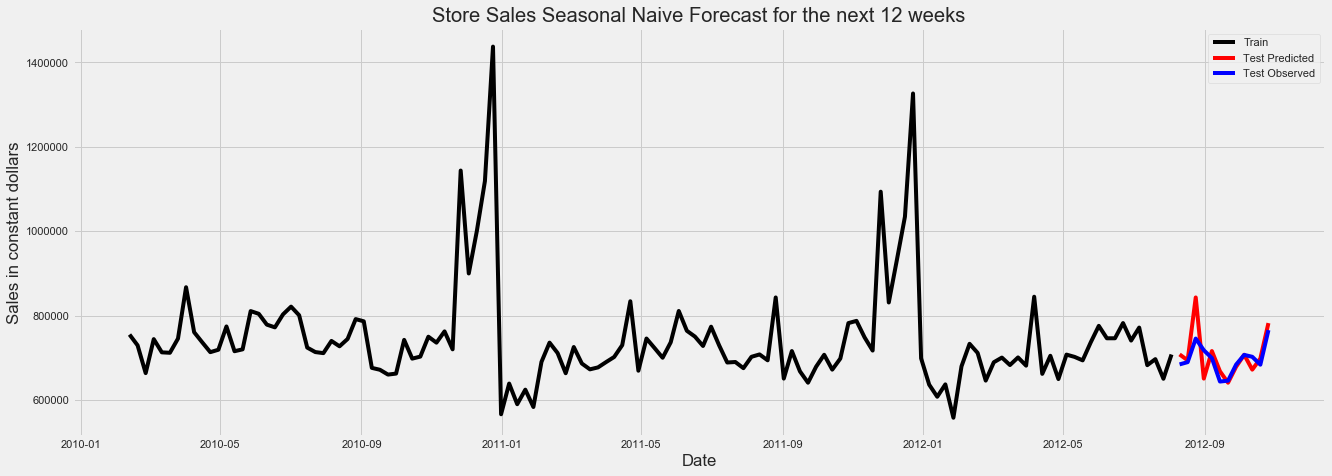

In [31]:
plt.figure(figsize=(20, 7))
plt.plot(train_df.index, train_df[["Adjusted_Weekly_Sales"]], label="Train", color="black")
plt.plot(test_df.index, test_df["Adjusted_Weekly_Sales_t-52"], label="Test Predicted", color="red")
plt.plot(test_df.index, test_df["Adjusted_Weekly_Sales"], label="Test Observed", color="blue")
plt.title("Store Sales Seasonal Naive Forecast for the next 12 weeks")
plt.xlabel("Date")
plt.ylabel("Sales in constant dollars")
plt.legend()
plt.show();

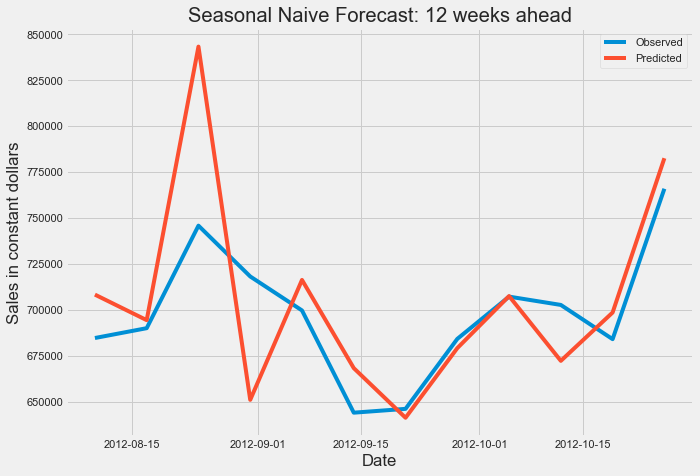

In [32]:
plt.plot(test_df["Adjusted_Weekly_Sales"], label="Observed")
plt.plot(test_df["Adjusted_Weekly_Sales_t-52"], label="Predicted")
plt.title("Seasonal Naive Forecast: 12 weeks ahead")
plt.xlabel("Date")
plt.ylabel("Sales in constant dollars")
plt.legend()
plt.show();

## Forecast Error
I'm going to use **Scaled MAE**, which scales the mean absolute error to average sales. 

$ MAE \% = \frac{\frac{1}{n}\sum_{i=0}^{n}\mid y_i-\hat{y_i}\mid}{\frac{1}{n}\sum_{i=0}^{n} y_i} = \frac{\sum_{i=0}^{n}\mid y-\hat{y}\mid}{\sum_{i=0}^{n} y}$

The other metric is **Weighted Mean Absolute Error**, which weighs error made for the holidays 5 times more.

$ WMAE = \frac{1}{\sum w_i}\sum_{i=0}^{n} w_i \mid y_i- \hat{y_i} \mid $

- n is the number of rows
- \\( \hat{y}_i \\) is the predicted sales
- \\( y_i \\) is the actual sales
- \\( w_i \\) are weights. w = 5 if the week is a holiday week, 1 otherwise

In [37]:
import math

mean_absolute_error = abs(test_df["Error"]).mean()
holiday_weighted_mean_absolute_error = abs(test_df["Holiday_Weighted_Error"]).sum() / test_df["Weight"].sum()
scaled_mean_absolute_error = mean_absolute_error / test_df["Adjusted_Weekly_Sales"].mean()

print("MAE: ", mean_absolute_error)
print("Average Demand in test data: {} in constant dollars".format(int(test_df["Adjusted_Weekly_Sales"].mean())))
print("Holiday Weighted Mean Absolute Error: {} in constant dollars".format(round(holiday_weighted_mean_absolute_error,2)))
print("Scaled Mean Absolute Error: {} % in constant dollars".format(round(scaled_mean_absolute_error*100,2)))

MAE:  25417.538110545156
Average Demand in test data: 697893 in constant dollars
Holiday Weighted Mean Absolute Error: 23211.2 in constant dollars
Scaled Mean Absolute Error: 3.64 % in constant dollars


Not bad for the naive benchmark forecast. This model tends to overestimate by 7516 constant dollars on average.